In [1]:
from onemetric.cv.object_detection.mean_average_precision import MeanAveragePrecision
from onemetric.cv.object_detection.confusion_matrix import ConfusionMatrix

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
classes = list({'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'dining table': 16, 'potted plant': 17, 'sofa': 18, 'tvmonitor': 19}.keys())

### PREDICTIONS TRAIN

In [16]:
predictions = np.load('./results/predictions.npy', allow_pickle=True).tolist()
labels = np.load('./results/labels.npy', allow_pickle=True).tolist()

In [6]:
mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

In [7]:
mean_avg_prec.value

0.3856635330605623

In [8]:
confusion_matrix = ConfusionMatrix.from_detections(
     true_batches=labels, 
     detection_batches=predictions,
    num_classes=20
)

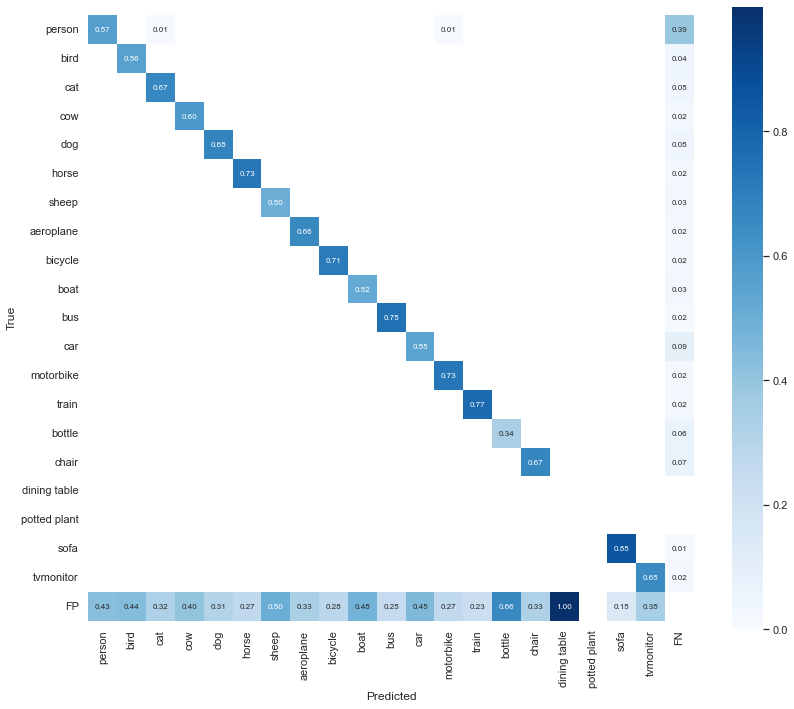

In [13]:
confusion_matrix.plot(".", class_names=classes, normalize=True)

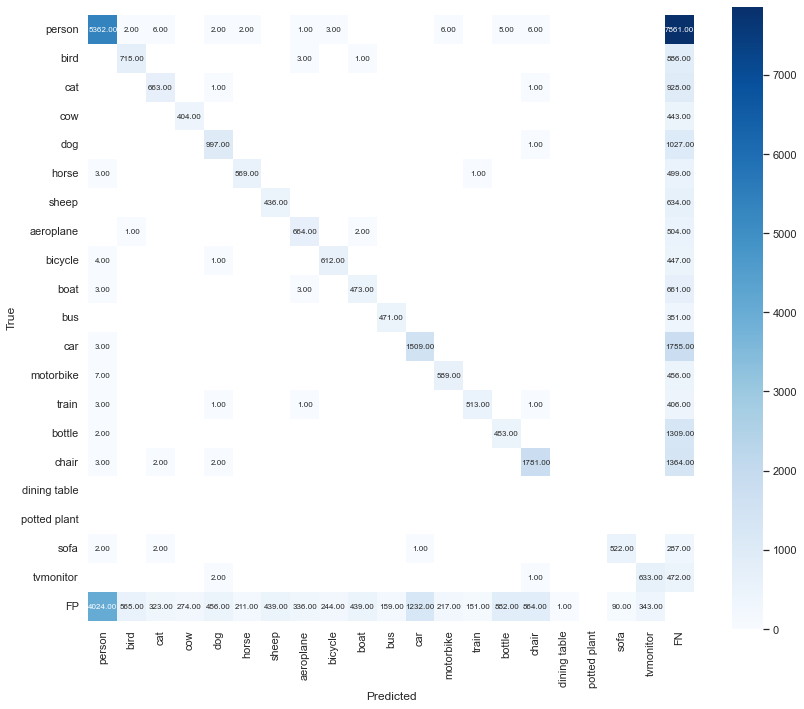

In [14]:
confusion_matrix.plot(".", class_names=classes, normalize=False)

### PREDICTIONS TEST

In [17]:
predictions = np.load('./results/predictions_test.npy', allow_pickle=True).tolist()
labels = np.load('./results/labels_test.npy', allow_pickle=True).tolist()

mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

confusion_matrix = ConfusionMatrix.from_detections(
     true_batches=labels, 
     detection_batches=predictions,
    num_classes=20
)

mean_avg_prec.value

0.009774601638618697

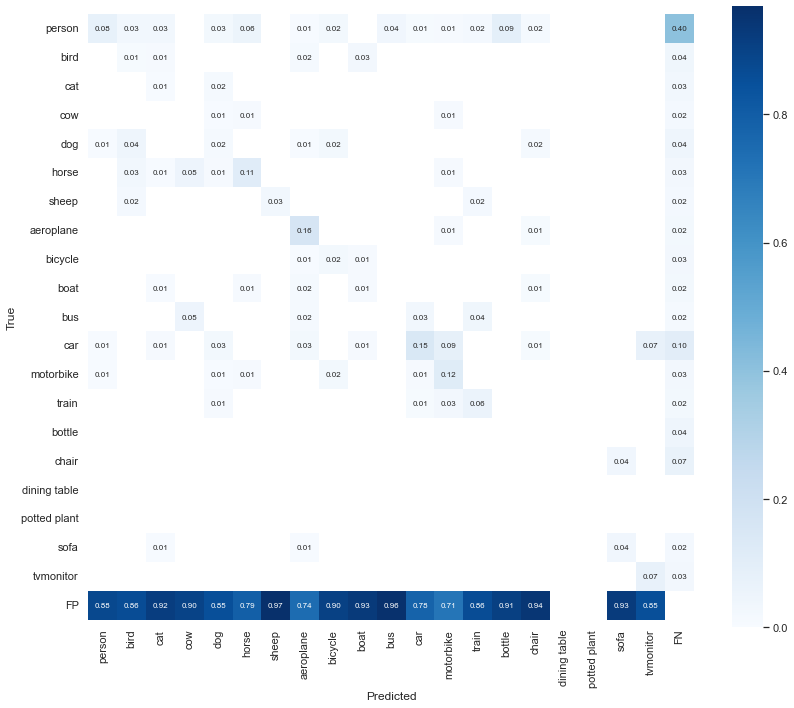

In [20]:
confusion_matrix.plot(".", class_names=classes, normalize=True)
plt.savefig("cm.png")

### One batch

In [18]:
predictions = np.load('./results/predictions_one_batch.npy', allow_pickle=True).tolist()
labels = np.load('./results/labels_one_batch.npy', allow_pickle=True).tolist()

mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

confusion_matrix = ConfusionMatrix.from_detections(
     true_batches=labels, 
     detection_batches=predictions,
    num_classes=20
)

mean_avg_prec.value

0.28125

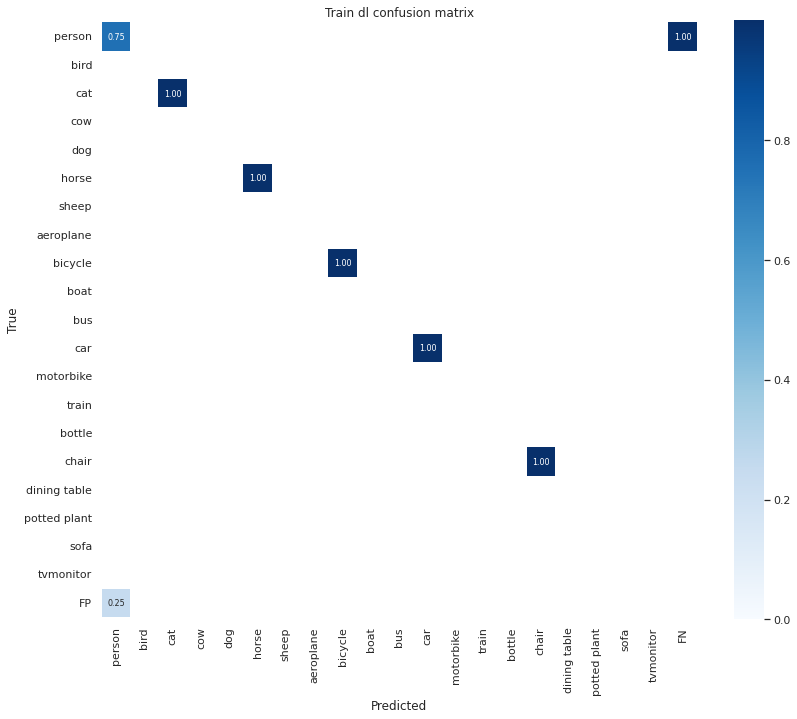

In [17]:
confusion_matrix.plot(".", class_names=classes, normalize=True)
plt.title("Train dl confusion matrix")
plt.show()

### Evaluate dropout 0.6

In [4]:
import evaluation

In [5]:
import torch
import architecture
import utils
import dataset
from torchvision.models.vgg import *
import torch.nn as nn

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 80
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.00001
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

In [8]:
config = dict(
    # TRAINING PARAMS AND HYPERPARAMS
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer="Adam",
    momentum=MOMENTUM, # only needed for SGD
    # MODEL
    model_predefined=False,
    checkpoint=None, # only needed if model_predefined=True
    # DATASET PARAMS AND HYPERPARAMS
    batch_size=32,
    train_years=[2007],
    batch_norm=True,
    include_difficult=False,
    transforms=True,
    is_one_batch=False,
    # OTHER PARAMS TO SET
    fc_dropout=0.0, # set value of dropout in fully connected layer for overfitting, 0 means no dropout
    grid_size=7, # in paper this is S
    bounding_boxes=2, # in paper this is B
    classes=20 # in paper this is C
)

In [9]:
test_dl = dataset.prepare_test_data(config["batch_size"], config["include_difficult"])

Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data


Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([32, 3, 448, 448])
Objects batch shape for training: 32
Labels matrix batch shape for training: torch.Size([32, 7, 7, 25])
Size of training set: 2528
Size of validation set: 2528
Sample batch for training dataloader is presented below:


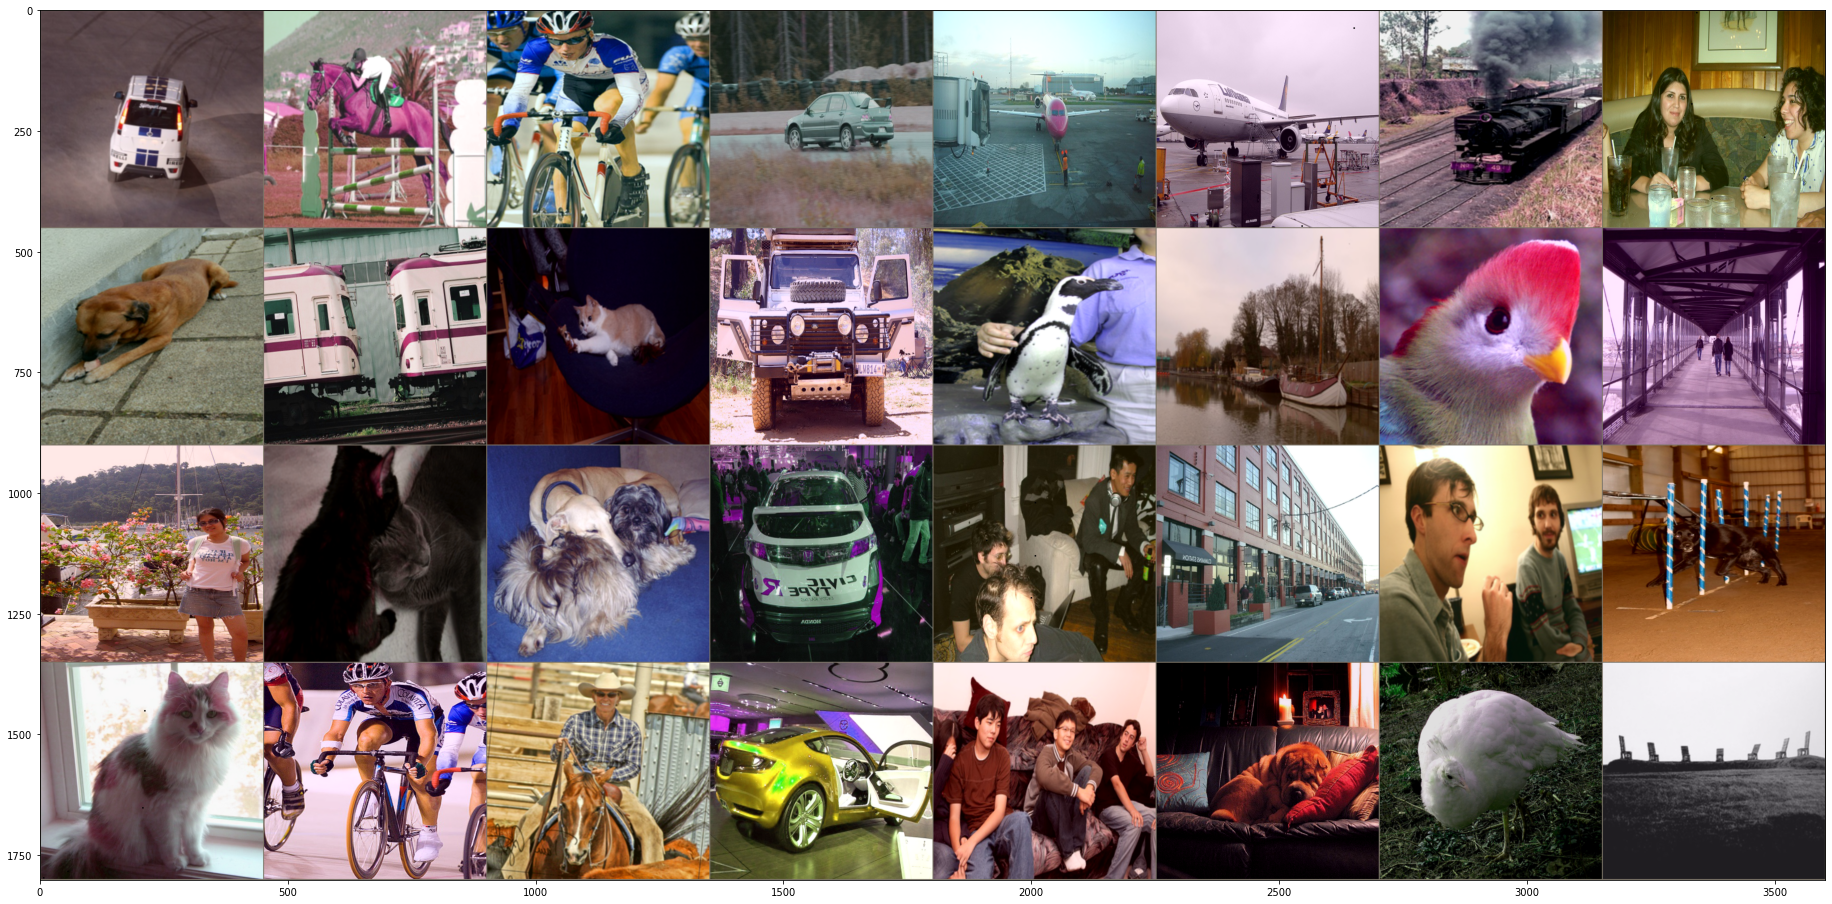

In [12]:
train_dl_predef, val_dl_predef = dataset.prepare_data(config["batch_size"], config["include_difficult"], config["transforms"], config["train_years"])

In [10]:
def evaluate_from_file(filename, test_dl_predef, test_dl=True):
    model = architecture.darknet(True)
    model.to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.00008
    )
    
    utils.load_checkpoint(filename, model, optimizer)
    
    evaluation.evaluate_model(model, test_dl_predef, test_dl=test_dl)

In [ ]:
evaluate_from_file("./163_drop_60_epoch60.pth.tar", train_dl_predef)

--- Loading checkpoint ---


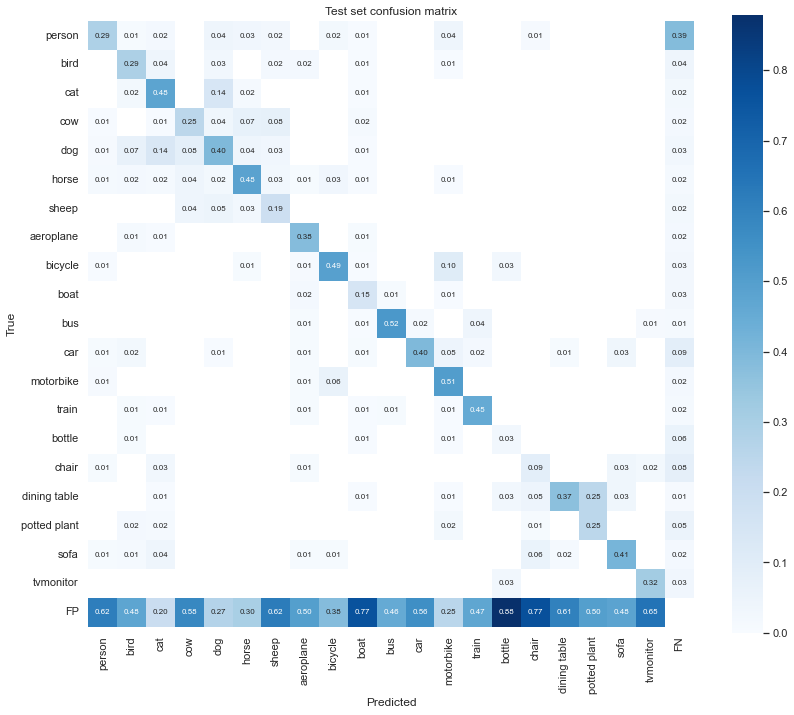

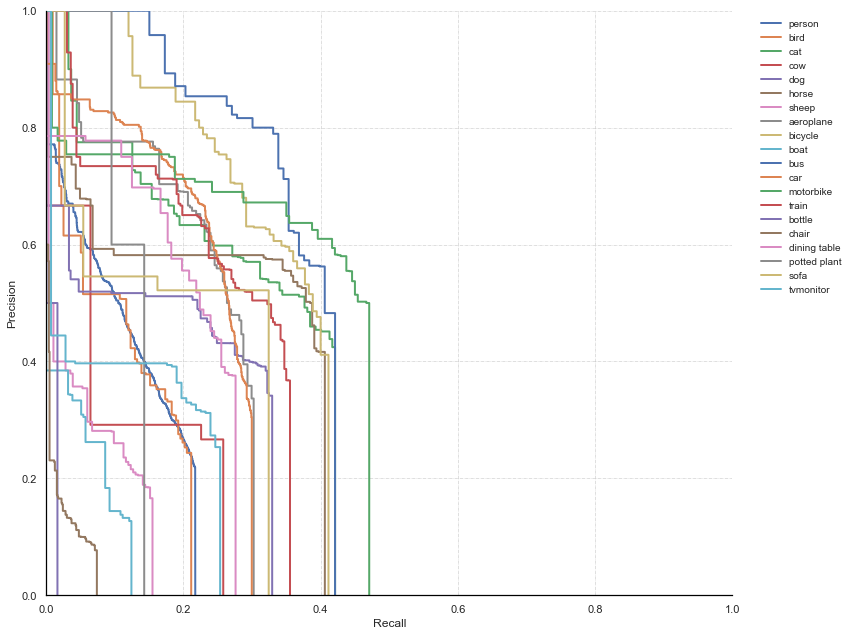

Test set MAP for this model is equal to: 0.16899240309929878


In [11]:
evaluate_from_file("./163_drop_60_epoch60.pth.tar", test_dl_predef)

--- Loading checkpoint ---


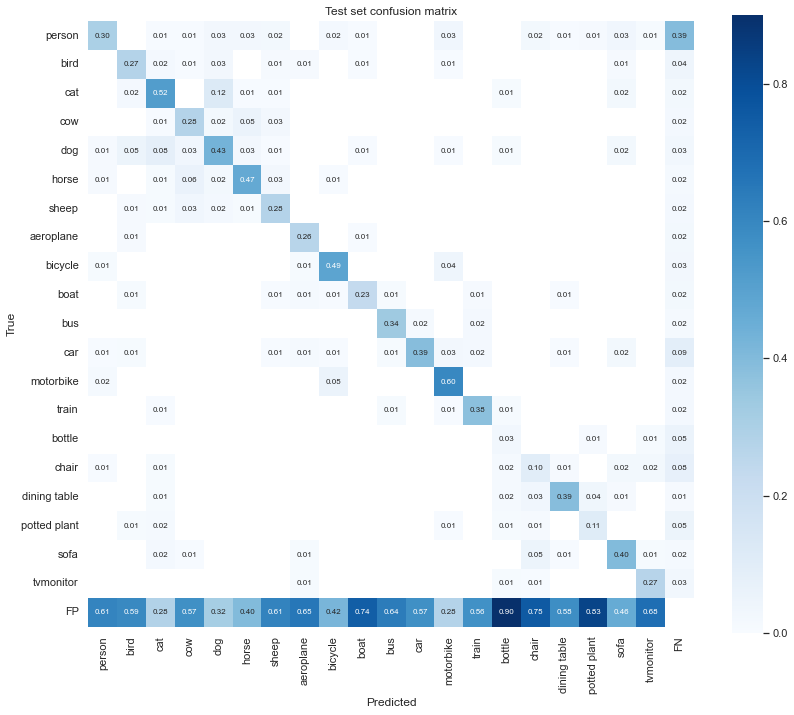

Test set MAP for this model is equal to: 0.14995715880789456


In [14]:
# overtrained
evaluate_from_file("./TRAINED_163_176.pth.tar", test_dl_predef)

--- Loading checkpoint ---


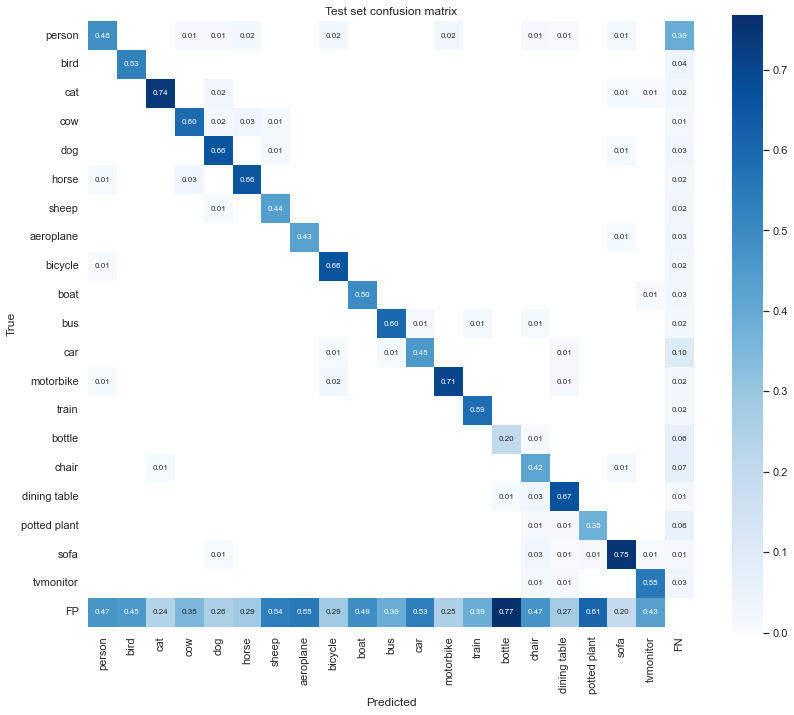

Test set MAP for this model is equal to: 0.3543688172792393


In [9]:
# overtrained
evaluate_from_file("./TRAINED_163_176.pth.tar", train_dl_predef)

### VGG YOLO HYBRID

--- Loading checkpoint ---


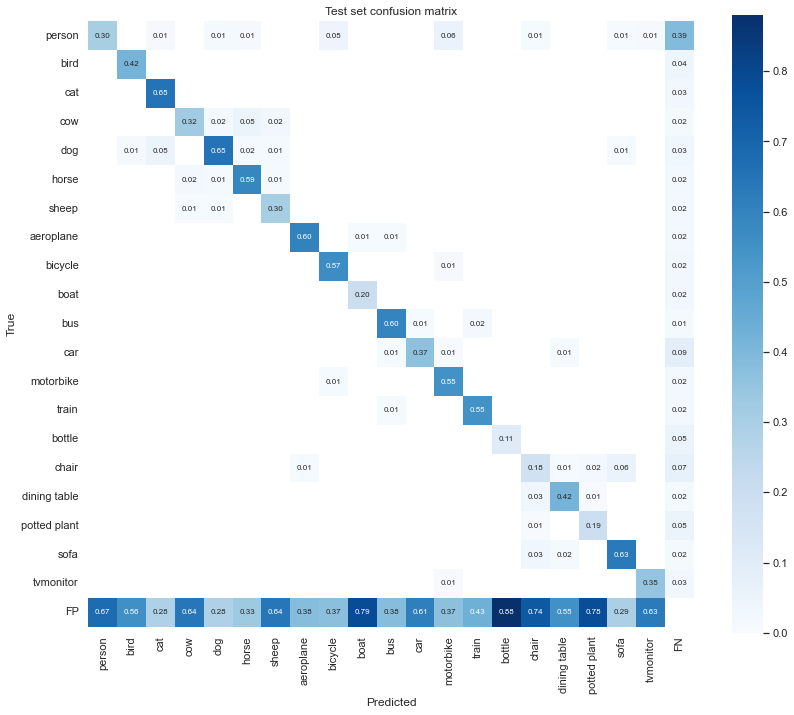

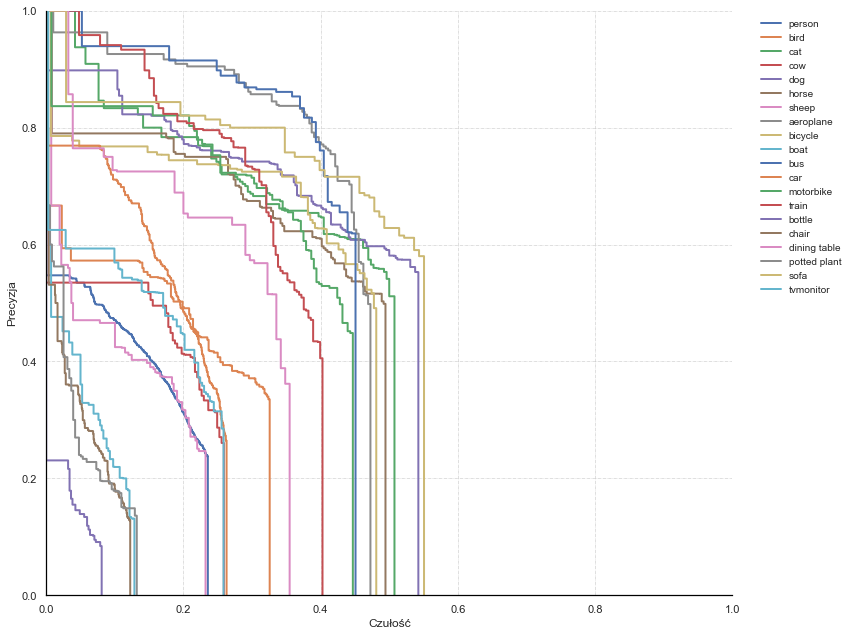

Test set MAP for this model is equal to: 0.22725948612240132


In [11]:
model = vgg16(pretrained=False)
model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.Dropout(0.5),
        # nn.BatchNorm1d(4096),
        nn.LeakyReLU(0.1),
        nn.Linear(4096, 7 * 7 * (2 * 5 + 20)),
)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.00008
)

utils.load_checkpoint("./VGG_YOLO.pth.tar", model, optimizer)

evaluation.evaluate_model(model, test_dl)

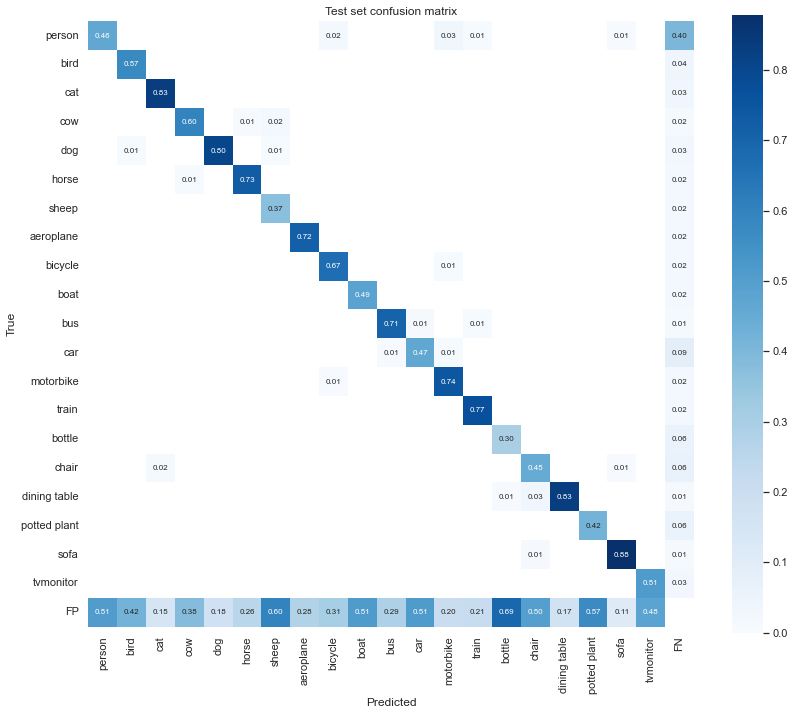

Test set MAP for this model is equal to: 0.4131666806922107


In [8]:
evaluation.evaluate_model(model, train_dl_predef)

In [43]:
images, labels, _ = iter(test_dl_predef).next()

In [44]:
images = images.to(device)

In [45]:
model.eval()

with torch.no_grad():
    # predictions are tensor (batch_size, 7, 7, 30) when S=7
    predictions = model(images)
    predictions = predictions.reshape(32, 7, 7, 30)
    


In [46]:
pred_bbox = utils.tensor_to_bbox_list(predictions, is_target=False)

### INNE

--- Loading checkpoint ---


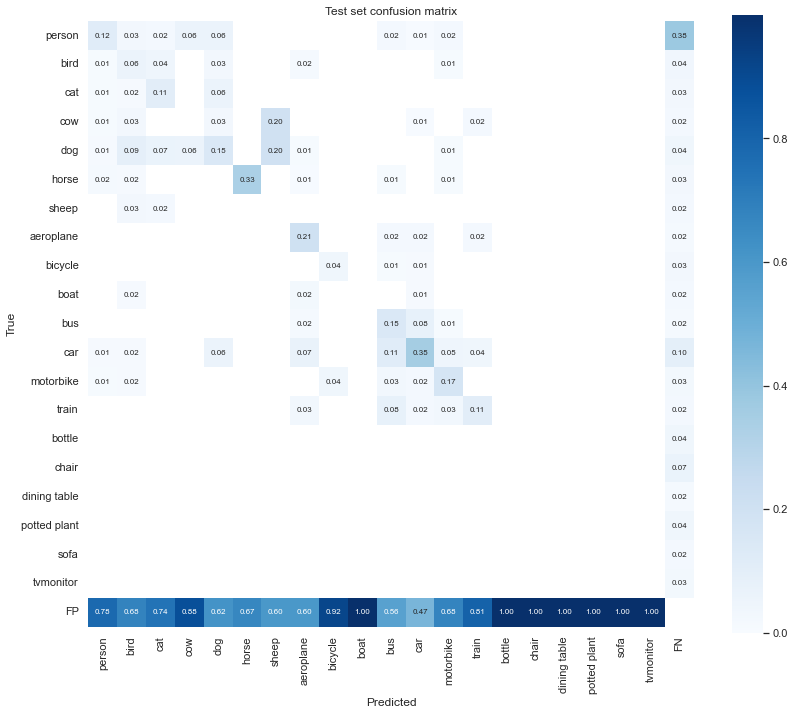

Test set MAP for this model is equal to: 0.019317817959192254


In [23]:
evaluate_from_file("./yolo_test.pth (2).tar", test_dl_predef)

--- Loading checkpoint ---


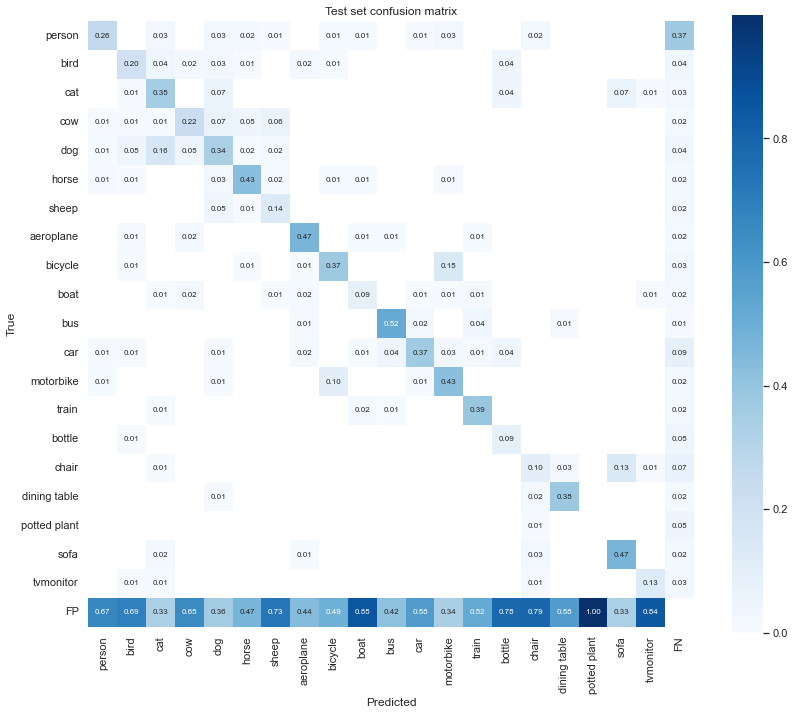

Test set MAP for this model is equal to: 0.13563195112537113


In [21]:
evaluate_from_file("./yolo_test.pth (3).tar", test_dl_predef)

--- Loading checkpoint ---


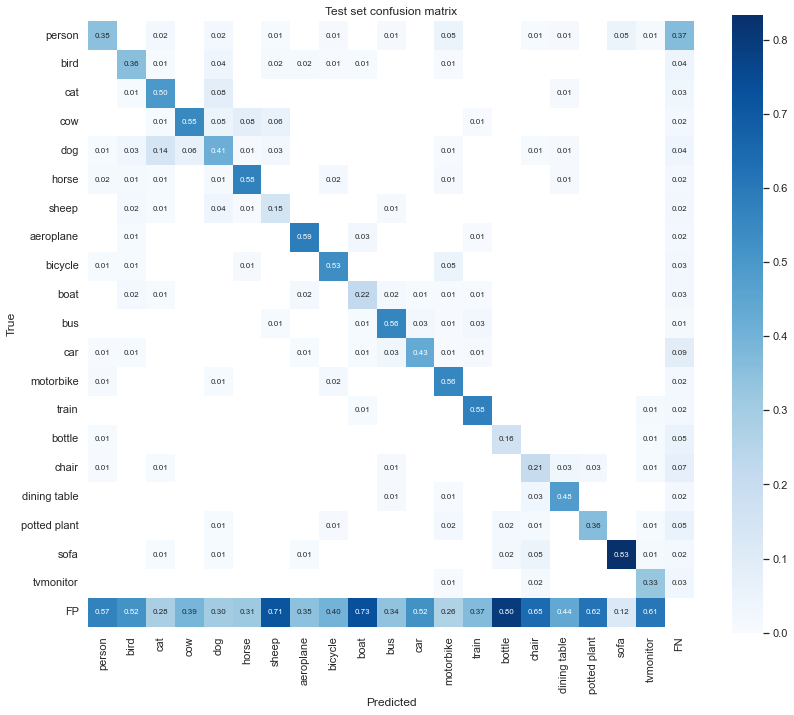

Test set MAP for this model is equal to: 0.22619813917506643


In [19]:
evaluate_from_file("./yolo_test.pth (3).tar", train_dl_predef)

### Precision Recall curve

In [11]:
from onemetric.cv.object_detection.mean_average_precision import MeanAveragePrecision
from onemetric.cv.object_detection.confusion_matrix import ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np

In [9]:
predictions = np.load('./results/predictions.npy', allow_pickle=True).tolist()
labels = np.load('./results/labels.npy', allow_pickle=True).tolist()

In [ ]:
mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

In [10]:
mean_avg_prec.value

0.3856635330605623

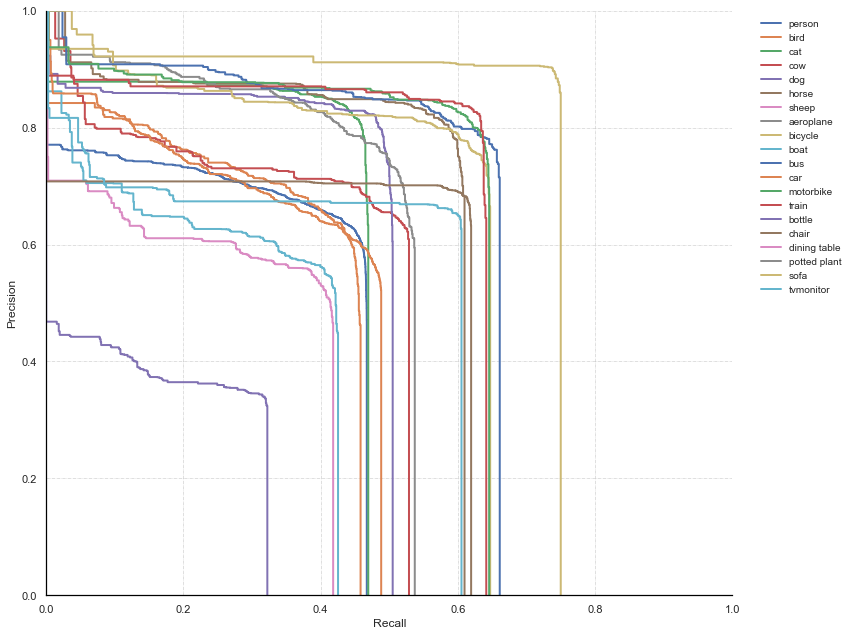

In [18]:
mean_avg_prec.plot("try.png", class_names=classes)

### MODELS 18.01.2022

--- Loading checkpoint ---


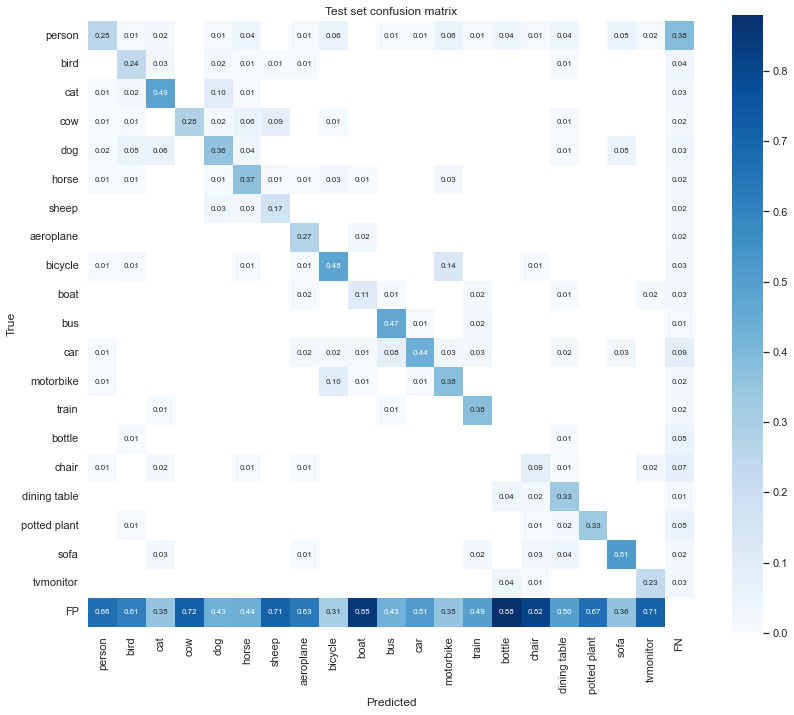

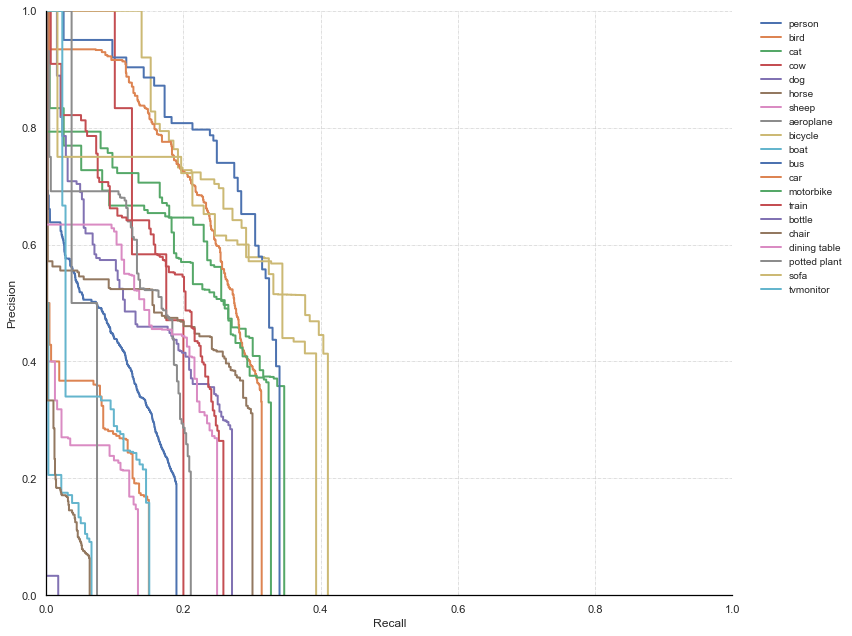

Test set MAP for this model is equal to: 0.13493094602369154


In [13]:
evaluate_from_file("./train_without_val2007.pth.tar", test_dl)

--- Loading checkpoint ---


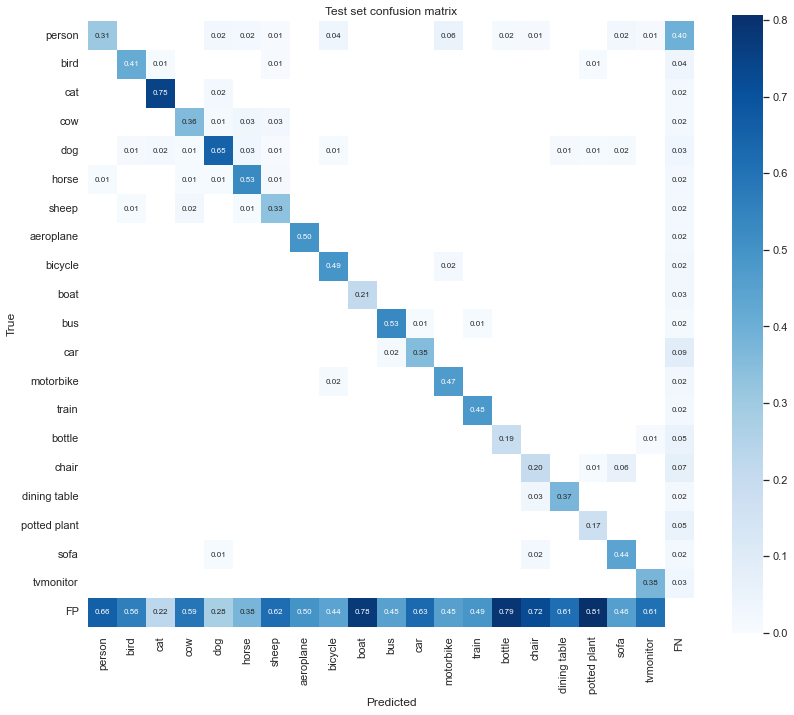

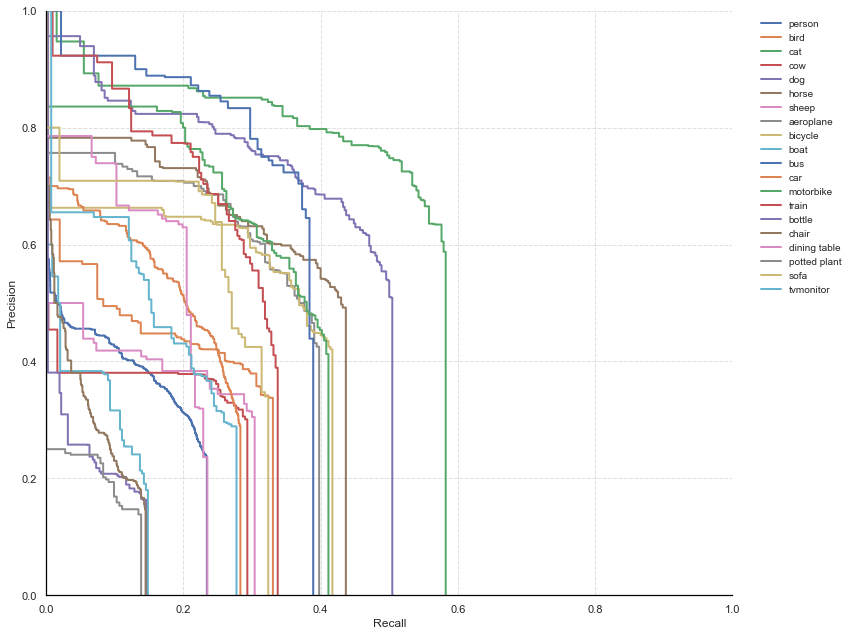

Test set MAP for this model is equal to: 0.19581249398177122


In [12]:
from torchvision.models.vgg import *
import torch.nn as nn

model = vgg16(pretrained=False)
model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.Dropout(0.5),
        # nn.BatchNorm1d(4096),
        nn.LeakyReLU(0.1),
        nn.Linear(4096, 7 * 7 * (2 * 5 + 20)),
)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.00008
)

utils.load_checkpoint("./vgg_new_model_trained.pth.tar", model, optimizer)

# 46 iteracji
evaluation.evaluate_model(model, test_dl)

--- Loading checkpoint ---


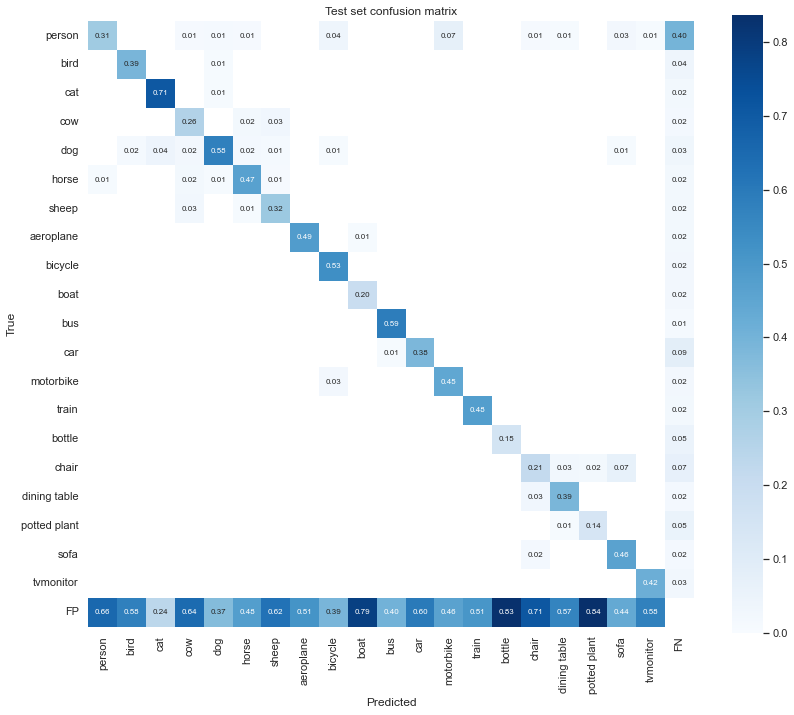

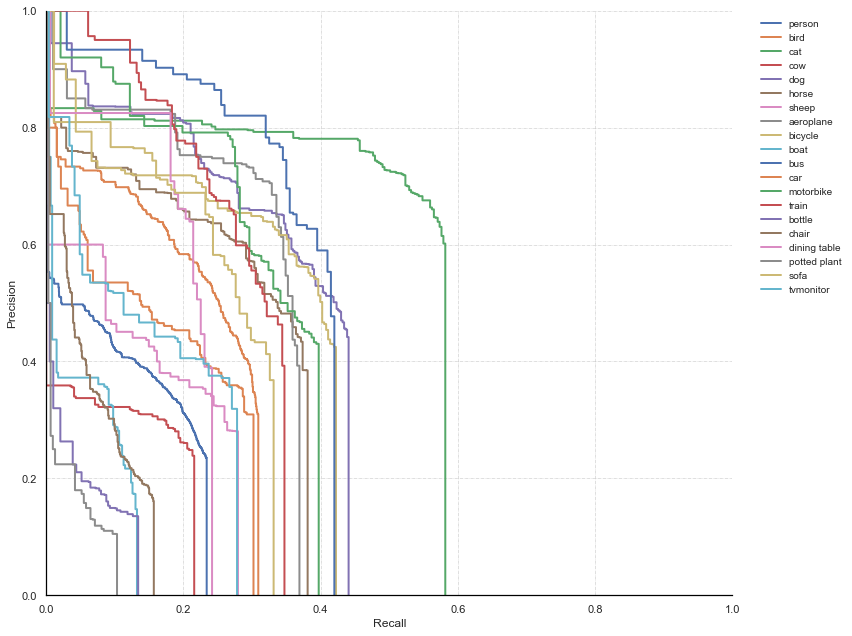

Test set MAP for this model is equal to: 0.19460456847773627


In [21]:
from torchvision.models.vgg import *
import torch.nn as nn

model = vgg16(pretrained=False)
model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.Dropout(0.5),
        # nn.BatchNorm1d(4096),
        nn.LeakyReLU(0.1),
        nn.Linear(4096, 7 * 7 * (2 * 5 + 20)),
)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.00008
)

utils.load_checkpoint("./vgg_new_model_trained_p2.pth.tar", model, optimizer)

# 46 iteracji
evaluation.evaluate_model(model, test_dl)

In [28]:
model = architecture.darknet(True)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.00008
)

utils.load_checkpoint("./163_drop_60_epoch60.pth.tar", model, optimizer)

--- Loading checkpoint ---


In [11]:
model = vgg16(pretrained=False)
model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.Dropout(0.5),
        # nn.BatchNorm1d(4096),
        nn.LeakyReLU(0.1),
        nn.Linear(4096, 7 * 7 * (2 * 5 + 20)),
)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.00008
)

utils.load_checkpoint("./VGG_YOLO.pth.tar", model, optimizer)

--- Loading checkpoint ---


In [217]:
import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\OneDrive\\OneDrive - Politechnika Warszawska\\0.inzynierka_windows\\YOLO-recreated\\utils.py'>

In [14]:
predictions, targets = utils.pred_and_target_boxes(test_dl, model, single_batch=False, conf_threshold=0.2)

In [160]:
targets[0]

array([  0.        ,   4.        ,  60.91784703, 215.04      ,
       247.47875354, 332.416     ])

In [302]:
predictions_2, targets = utils.pred_and_target_boxes(test_dl, model, single_batch=False, nms=False, conf=False, conf_threshold=0.9)

In [ ]:
predictions_3, targets = utils.pred_and_target_boxes(test_dl, model, single_batch=False, nms=False, conf_threshold=0.1)

In [12]:
test_dataset = dataset.VOCDataset(2007, "test", False, None)

Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data


In [13]:
classes_dict = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}

inv_classes_dict = {v: k for k, v in classes_dict.items()}
# inv_classes_dict[predictions[0][1]]

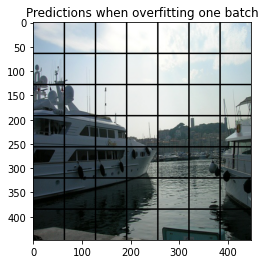

In [16]:
import cv2
import matplotlib.pyplot as plt

FONT = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
red = (255, 0, 0)
black = (0, 0, 0)
thickness = 1
font_size = 2.5

# for i in range(50):
i=500
un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
# denormalize the image
npimg = un_norm(test_dataset[i][0].clone()).numpy()
npimg = npimg.transpose((1, 2, 0)).copy()
npimg = (npimg * 255).astype(np.uint8)

n=0

w = 448//7
for j in range(1,7):
    x = w*j
    cv2.line(npimg, (0, x), (448, x), color=black, thickness=2)
    cv2.line(npimg, (x, 0), (x, 448), color=black, thickness=2)
    
overlay = npimg.copy()

for idx, class_no, x, y, x2, y2 in targets:
# for idx, class_no, conf, x, y, x2, y2 in predictions:
    if idx == i:
        # x, y, x2, y2 = int(x*448), int(y*448), int(x2*448), int(y2*448)
        x, y, x2, y2 = int(x), int(y), int(x2), int(y2)
        continue
        if n == 0:
            cv2.rectangle(npimg, (x, y), (x2, y2), green, 4)
            cv2.circle(npimg, ((x+x2)//2, (y+y2)//2), 3, green, 5)
        else:
            cv2.rectangle(npimg, (x, y), (x2, y2), red, 4)
            cv2.circle(npimg, ((x+x2)//2, (y+y2)//2), 3, red, 5)
        n+=1
        cv2.putText(npimg, "{:.2f}".format(class_no), (x, y), FONT, font_size, red, thickness + 2)
        cv2.putText(npimg, inv_classes_dict[class_no], (x, y), FONT, font_size, (255,255,255), thickness + 2)
        cv2.putText(npimg, "{:.3f}".format(conf), (x, y), FONT, font_size, red, thickness + 2)
        


alpha = 0.4  # Transparency factor.

# Following line overlays transparent rectangle over the image
# image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

# Display the image
plt.title("Predictions when overfitting one batch")
plt.imsave("with_nms.png", npimg)
plt.imshow(npimg)

In [364]:
w

64

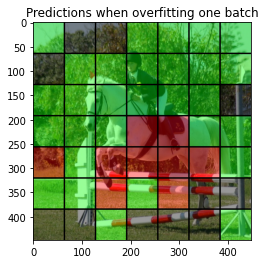

In [365]:
import cv2
import matplotlib.pyplot as plt

un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
# denormalize the image
npimg = un_norm(test_dataset[i][0].clone()).numpy()
npimg = npimg.transpose((1, 2, 0)).copy()
npimg = (npimg * 255).astype(np.uint8)

overlay = npimg.copy()
alpha = 0.4

for idx, class_no, conf, x, y, x2, y2 in predictions_2:
    if idx == i:
        x, y, x2, y2 = int(x*448), int(y*448), int(x2*448), int(y2*448)
        x=(x+x2)//2
        y=(y+y2)//2
        cell_x, cell_y = x // w, y // w
        x, y, x2, y2 = cell_x*w, cell_y*w, (cell_x+1)*w, (cell_y+1)*w
        
        if inv_classes_dict[class_no] == "person":
            cv2.rectangle(overlay, (x, y), (x2, y2), green, -1)
        elif inv_classes_dict[class_no] == "horse":
            cv2.rectangle(overlay, (x, y), (x2, y2), red, -1)
        else:
            cv2.rectangle(overlay, (x, y), (x2, y2), (0,0,0), -1)
#         cv2.putText(npimg, "{:.2f}".format(class_no), (x, y), FONT, font_size, red, thickness + 2)
        # cv2.putText(npimg, inv_classes_dict[class_no], (x, y), FONT, font_size, red, thickness + 2)
        # cv2.putText(npimg, "{:.3f}".format(conf), (x, y), FONT, font_size, red, thickness + 2)
        
for j in range(1,7):
    x = w*j
    cv2.line(npimg, (0, x), (448, x), color=black, thickness=2)
    cv2.line(npimg, (x, 0), (x, 448), color=black, thickness=2)
    cv2.line(overlay, (0, x), (448, x), color=black, thickness=2)
    cv2.line(overlay, (x, 0), (x, 448), color=black, thickness=2)

        
image_new = cv2.addWeighted(overlay, alpha, npimg, 1 - alpha, 0)

# Display the image
plt.title("Predictions when overfitting one batch")
plt.imsave("without_nms.png", image_new)
plt.imshow(image_new)

In [34]:
import cv2
import matplotlib.pyplot as plt

# f, axarr = plt.subplots(4,4, figsize=(50,50))

good = [16, 17, 32, 34, 44, 62, 112, 158]
bad = [2, 26, 55, 64, 126, 165]

un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
for j in [0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160]:
    for i in range(j, j+16):
        if i in bad or i in good:
            # denormalize the image
            npimg = un_norm(test_dataset[i][0].clone()).numpy()
            npimg = npimg.transpose((1, 2, 0)).copy()
            npimg = (npimg * 255).astype(np.uint8)

            for idx, class_no, conf, x, y, x2, y2 in predictions:
            # for idx, class_no, x, y, x2, y2 in predictions:
                if idx == i:
                    x, y, x2, y2 = int(x*448), int(y*448), int(x2*448), int(y2*448)
                    cv2.rectangle(npimg, (x, y), (x2, y2), green, thickness)
            #         cv2.putText(npimg, "{:.2f}".format(class_no), (x, y), FONT, font_size, red, thickness + 2)
                    cv2.putText(npimg, inv_classes_dict[class_no], (x, y), FONT, font_size, red, thickness + 2)
                    # cv2.putText(npimg, "{:.3f}".format(conf), (x, y), FONT, font_size, red, thickness + 2)

            # Display the image
            # axarr[i//4, i%4].title("Pred {}".format(i))

            if i in good:      
                plt.imsave("predictions\\"+str(i)+"_good.png", npimg)
            else:
                plt.imsave("predictions\\"+str(i)+"_bad.png", npimg)
            # axarr[(i-j)//4, i%4].imshow(npimg)

In [35]:
predictions, labels = utils.pred_and_target_boxes_map(test_dl, model, single_batch=False, conf_threshold=0.05)

In [36]:
dataset.save_test_my_dataset("C:\\OneDrive\\OneDrive - Politechnika Warszawska\\0.inzynierka_windows\\mAP\\input\\detection-results", predictions)

100%|██████████| 4952/4952 [00:09<00:00, 533.74it/s]


### CHECK DIFFERENT CONF_THRESHOLD

In [15]:
confidences = []
maps = []

for conf_threshold in np.arange(0.01, 0.5, 0.01):
    confidences.append(conf_threshold)
    predictions, labels = utils.pred_and_target_boxes_map(test_dl, model, single_batch=False, conf_threshold=conf_threshold)

    mean_avg_prec = MeanAveragePrecision.from_detections(
        true_batches=labels, 
        detection_batches=predictions, 
        num_classes=20, 
        iou_threshold=0.5
    )
    
    maps.append(mean_avg_prec.value)

In [16]:
for conf_threshold in np.arange(0.5, 0.99, 0.01):
    confidences.append(conf_threshold)
    predictions, labels = utils.pred_and_target_boxes_map(test_dl, model, single_batch=False, conf_threshold=conf_threshold)

    mean_avg_prec = MeanAveragePrecision.from_detections(
        true_batches=labels, 
        detection_batches=predictions, 
        num_classes=20, 
        iou_threshold=0.5
    )
    
    maps.append(mean_avg_prec.value)

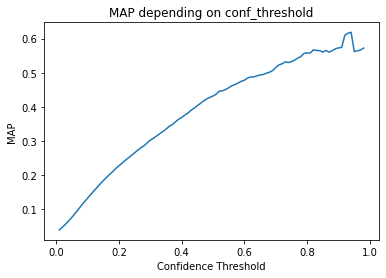

In [24]:
plt.plot(confidences, maps)
plt.xlabel("Confidence Threshold")
plt.ylabel("MAP")
plt.title("MAP depending on conf_threshold")
plt.show()

In [25]:
maps[93]

0.6187840642240485

In [19]:
predictions, labels = utils.pred_and_target_boxes_map(test_dl, model, single_batch=False, conf_threshold=0.5)

mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

In [20]:
mean_avg_prec.value

0.4320469674415531

In [22]:
confusion_matrix = ConfusionMatrix.from_detections(
     true_batches=labels, 
     detection_batches=predictions,
    num_classes=20
)

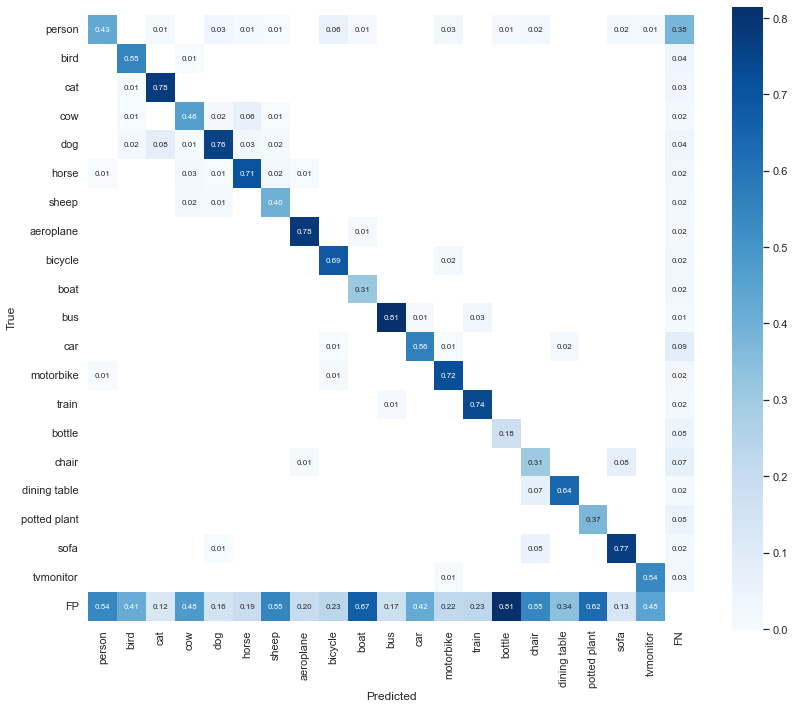

In [26]:
confusion_matrix.plot(".", class_names=classes, normalize=True)

In [13]:
predictions, labels = utils.pred_and_target_boxes_map(test_dl, model, single_batch=False, conf_threshold=0.9)

mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

In [14]:
mean_avg_prec.value

0.5590359778079111

In [15]:
confusion_matrix = ConfusionMatrix.from_detections(
     true_batches=labels, 
     detection_batches=predictions,
    num_classes=20
)

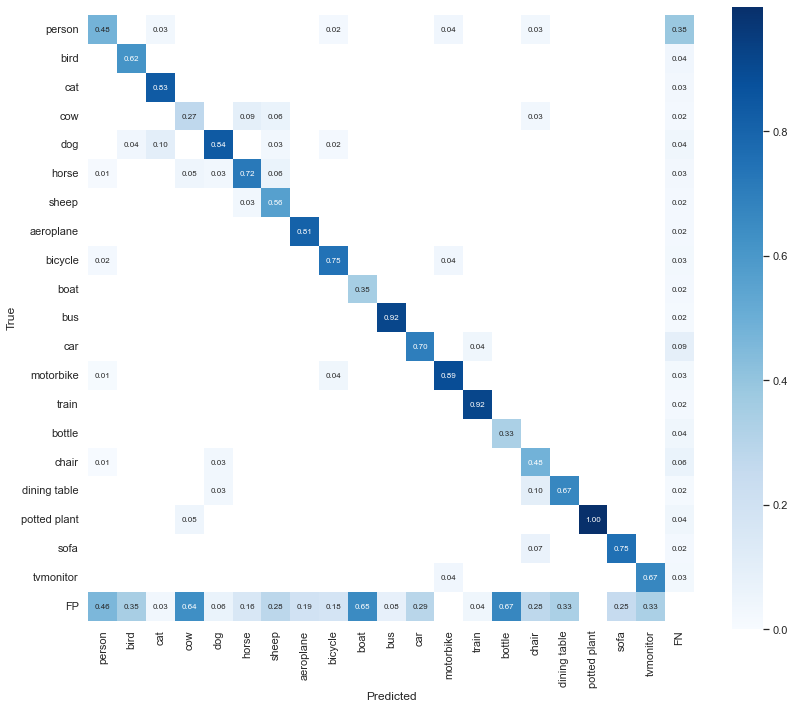

In [18]:
confusion_matrix.plot(".", class_names=classes, normalize=True)

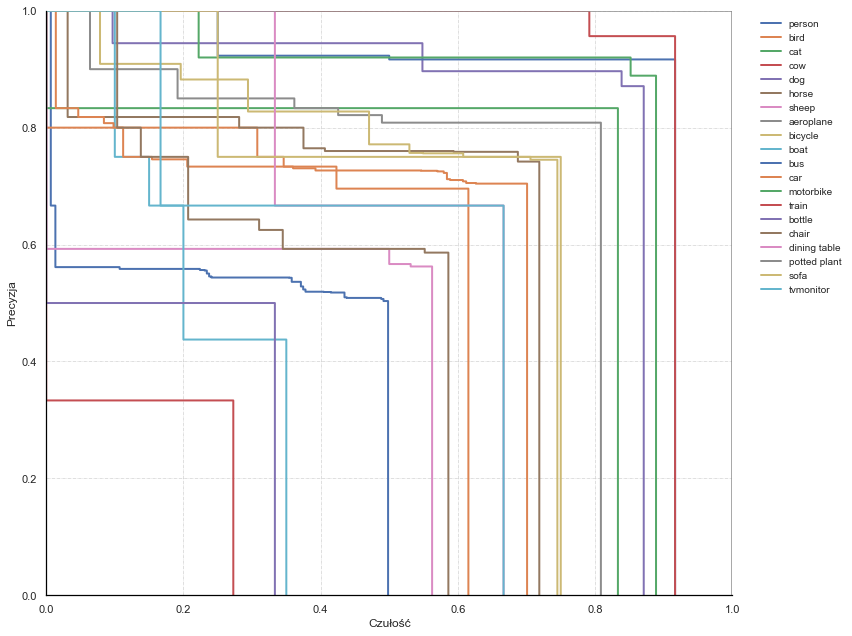

In [19]:
mean_avg_prec.plot("try.png", class_names=classes)

In [20]:
predictions, labels = utils.pred_and_target_boxes_map(train_dl_predef, model, single_batch=False, conf_threshold=0.5)

mean_avg_prec = MeanAveragePrecision.from_detections(
    true_batches=labels, 
    detection_batches=predictions, 
    num_classes=20, 
    iou_threshold=0.5
)

In [21]:
mean_avg_prec.value

0.6813189023761523

In [40]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### SPEED TESTING

In [41]:
import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\OneDrive\\OneDrive - Politechnika Warszawska\\0.inzynierka_windows\\YOLO-recreated\\utils.py'>

In [44]:
import tests

speedTest = tests.SpeedTesting(model, dataset.VOCDataset(2007, "test", False, transforms=False), "cpu", 400)

Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data


In [45]:
speedTest.speed_testing()

  0%|          | 0/4952 [00:00<?, ?it/s]

     + Total number of iterations: 399s
     + Total time cost: 153.9829728603363s
     + Average time cost: 0.3859222377452038s
     + Frame Per Second: 2.59


In [33]:
model = model.to("cpu")

In [382]:
data = dataset.VOCDataset(2007, "test", False, transforms=False)

Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data


In [387]:
model.eval()
inputs, _, _ = data[2]
inputs = inputs.to(device)
inputs = inputs.reshape(-1, 3, 448, 448)

with torch.no_grad():
    # predictions are tensor (batch_size, 7, 7, 30) when S=7
    predictions = model(inputs)
    predictions = predictions.reshape(-1, 7, 7, 30)
    
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [384]:
data_loader = [(data_loader[0], data_loader[1], data_loader[2])]

(tensor([[[-0.0972, -0.0972,  0.2624,  ...,  1.6153,  1.6667,  1.7523],
          [ 0.0569, -0.1143,  0.3309,  ...,  1.5639,  1.5982,  1.6495],
          [ 0.2111, -0.0629,  0.2796,  ...,  1.5810,  1.5125,  1.5982],
          ...,
          [-1.4329, -1.4158, -1.4158,  ...,  0.2111,  0.2624,  0.2453],
          [-1.5014, -1.4158, -1.4158,  ...,  0.1768,  0.2111,  0.2111],
          [-1.4843, -1.4672, -1.5014,  ...,  0.2282,  0.5022,  0.7077]],
 
         [[-0.3200, -0.3025,  0.0826,  ...,  1.8508,  1.9034,  1.9909],
          [-0.0924, -0.2150,  0.2052,  ...,  1.8508,  1.8508,  1.9034],
          [ 0.1352, -0.0924,  0.2402,  ...,  1.8683,  1.7983,  1.8508],
          ...,
          [-1.4405, -1.4405, -1.4230,  ...,  0.1877,  0.2402,  0.2227],
          [-1.5105, -1.4405, -1.4230,  ...,  0.1527,  0.1702,  0.1702],
          [-1.4930, -1.4755, -1.4930,  ...,  0.1877,  0.4678,  0.6779]],
 
         [[-0.7587, -0.8458, -0.5844,  ...,  2.5354,  2.5877,  2.6400],
          [-0.4450, -0.7064,

In [385]:
data[2][0].shape

torch.Size([3, 448, 448])

--- Loading checkpoint ---


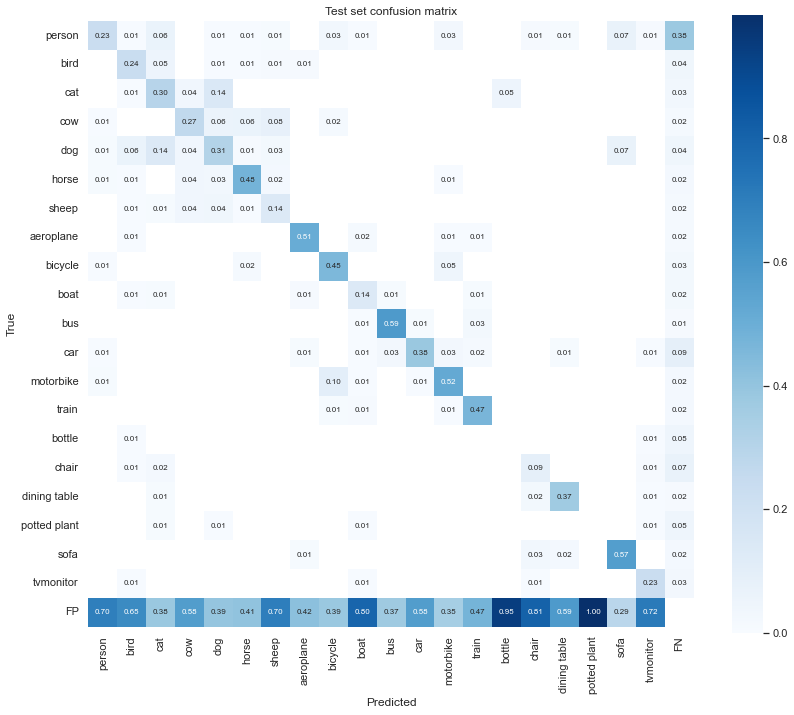

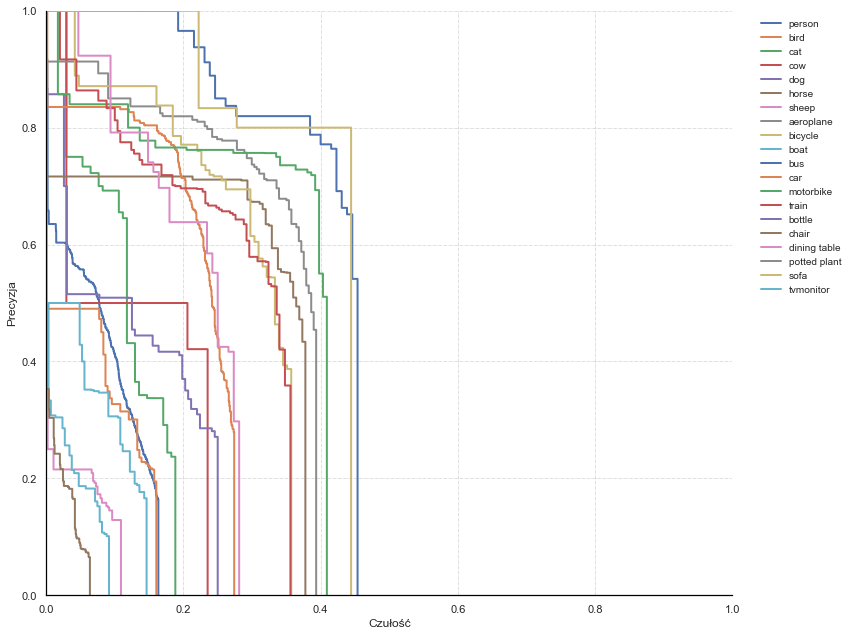

Test set MAP for this model is equal to: 0.16315379893900978


In [12]:
evaluate_from_file("./SGD_full_data.tar", test_dl)